In [39]:
# Import libraries
import numpy as np
import pandas as pd
from math import exp
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.model_selection import train_test_split
from scipy.linalg import eig
import warnings
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from constants import CURRENT_YR
import helper_functions as hf
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [41]:
# mode = "M" # Men's Tourney
mode = "W" # Women's Tourney

In [42]:
# Read in datasets
regular_seasons = pd.read_csv(f"{hf.get_kaggle_dir(CURRENT_YR, mode)}/{mode}RegularSeasonCompactResults.csv", dtype = {'WTeamID':str,'LTeamID':str})
teams = pd.read_csv(f"{hf.get_kaggle_dir(CURRENT_YR, mode)}/{mode}Teams.csv")

In [43]:
# Helper functions

def sorted_id(r):
    return ','.join([x for x in sorted([r['WTeamID'],r['LTeamID']])])

def get_home_away(r):
    if r['WLoc'] == 'H':
        return r['WTeamID'], r['LTeamID']
    elif r['WLoc'] == 'A':
        return r['LTeamID'], r['WTeamID']
    else:
        return 'NA', 'NA'

def get_home_away_score(r):
    if r['WLoc'] == 'H':
        return r['WScore'], r['LScore']
    elif r['WLoc'] == 'A':
        return r['LScore'], r['WScore']
    else:
        return np.nan, np.nan

def get_dif(r):
    if r['game_num'] == 1:
        return r['home_score'] - r['away_score']
    else:
        return r['away_score'] - r['home_score']

In [44]:
# Add columns to games dataframe for home_id, away_id, home_score, away_score, 
# and total matchups between the two teams that season

regular_seasons['sorted_ids'] = regular_seasons.apply(lambda r: sorted_id(r), axis=1)
regular_seasons['matchups'] = regular_seasons.groupby(['Season','sorted_ids'])['Season'].transform('size')
regular_seasons['home_id'], regular_seasons['away_id'] = zip(*regular_seasons.apply(lambda r: get_home_away(r), axis=1))
regular_seasons['home_score'], regular_seasons['away_score'] = zip(*regular_seasons.apply(lambda r: get_home_away_score(r), axis=1))

In [45]:
# Isolate home and home matchups to estimate the effect of home court advantage

home_and_home = regular_seasons.groupby(['home_id','away_id']).head(1).copy()
home_and_home['matchups'] = home_and_home.groupby(['Season','sorted_ids'])['Season'].transform('size')
home_and_home = home_and_home[home_and_home.matchups == 2]
home_and_home['game_num'] = home_and_home.groupby(['Season','sorted_ids'])['DayNum'].cumcount()+1
home_and_home['home_score'] = home_and_home.apply(lambda r: r['WScore'] if r['WLoc'] == 'H' else r['LScore'], axis=1)
home_and_home['away_score'] = home_and_home.apply(lambda r: r['WScore'] if r['WLoc'] == 'A' else r['LScore'], axis=1)
home_and_home['dif'] = home_and_home.apply(get_dif, axis=1)
home_and_home.set_index(['sorted_ids','game_num'], inplace=True)
home_and_home = home_and_home[['dif']].unstack()
home_and_home.columns = home_and_home.columns.get_level_values(1)
home_and_home['away_win'] = (home_and_home[2] > 0).map(int)

In [46]:
# Train logistic regression model to estimate probabily of beating an opposing team
# on away court given the point differential on home court

train_x = np.expand_dims(home_and_home[1].values, axis=-1)
train_y = home_and_home['away_win'].values
lr_model = LogisticRegression()
lr_model.fit(train_x,train_y)
print(lr_model.coef_)
print(lr_model.intercept_)

[[0.07181122]]
[-0.71579543]


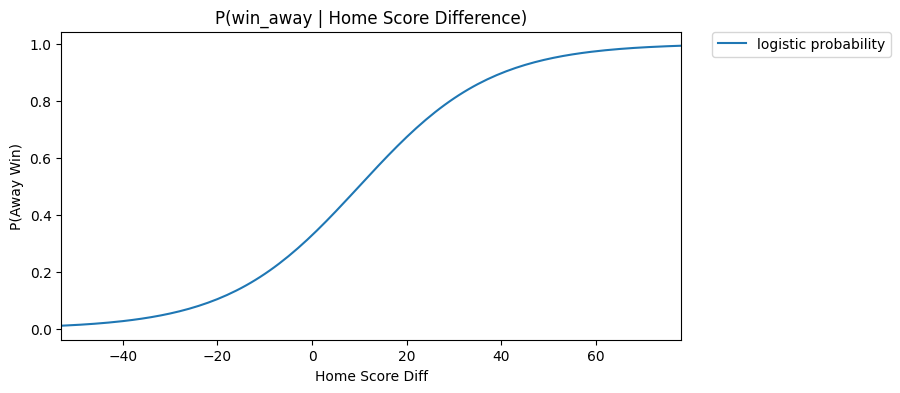

In [47]:
# Plot P(Away Win) vs Home Score Differential

# init
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
min_x = train_x.min()
max_x = train_x.max()
x_values = np.array(range(int(min_x), int(max_x) + 1))

# calculate probabilities
odds = np.exp(x_values * lr_model.coef_ + lr_model.intercept_)
log_prob = odds / (1. + odds)

# plot
ax.plot(x_values, log_prob[0], label="logistic probability")
ax.set_xlabel("Home Score Diff")
ax.set_ylabel("P(Away Win)")
ax.set_title("P(win_away | Home Score Difference)")
ax.set_xlim([min_x, max_x])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [48]:
# Calculate P (Away win) given home scoring differential
x_values = np.array(range(-100, 101))
odds = np.exp((x_values) * lr_model.coef_ + lr_model.intercept_)
prob = odds / (1. + odds)      
s_x_h = pd.DataFrame(data=prob[0], index=x_values, columns=["prob"])

In [49]:
# Find home court advantage
closest_index = (s_x_h['prob'] - 0.500).abs().idxmin()
print(f"Home court advantage is {closest_index} pts.")
print(s_x_h.loc[closest_index])

Home court advantage is 10 pts.
prob    0.500579
Name: 10, dtype: float64


In [50]:
s_x_h.loc[-20:20]

,prob
-20,0.104143
-19,0.111035
-18,0.118324
-17,0.126023
-16,0.134147
-15,0.142710
-14,0.151723
-13,0.161198
-12,0.171146
-11,0.181574


In [51]:
# Calculate P (better) given home, away, or neutral scorring differential

# Home
home_court_advantage = closest_index
x_values = np.array(range(-100, 101))
odds = np.exp((x_values + home_court_advantage) * lr_model.coef_ + lr_model.intercept_)
prob = odds / (1. + odds)                               
r_x_h = pd.DataFrame(data=prob[0], index=x_values, columns=["H"])

# Away
helper_df = 1. - r_x_h
helper_df.index = range(100, -101, -1)
r_x_a = helper_df.sort_index()
r_x_a.columns=['A']

# Neutral
x_values = np.array(range(-100, 101))
odds_neutral = np.exp((x_values + 2 * home_court_advantage) * lr_model.coef_ + lr_model.intercept_)
prob_neutral = odds_neutral / (1. + odds_neutral)                         
r_x_n = pd.DataFrame(data=prob_neutral[0], index=x_values, columns=["N"])

# Combine into single dataframe
game2_probs = pd.concat([r_x_h, r_x_a, r_x_n],axis=1)
game2_probs.reset_index(inplace=True)
game2_probs.columns = ['diff','H','A','N']
t_prob_lookup = pd.melt(game2_probs,id_vars='diff',var_name='loc',value_name='prob')

## Markov Creation

In [52]:
def get_team1_loc(r):
    if r['Team1'] == r['home_id']:
        return 'H'
    elif r['Team1'] == r['away_id']:
        return 'A'
    else:
        return 'N'
def get_team1_diff(r):
    if r['Team1'] == r['WTeamID']:
        return r['WScore']-r['LScore']
    else:
        return r['LScore']-r['WScore']

In [53]:
regular_seasons['Team1'] = regular_seasons['sorted_ids'].apply(lambda x: x.split(',')[0])
regular_seasons['Team2'] = regular_seasons['sorted_ids'].apply(lambda x: x.split(',')[1])
regular_seasons['Team1_loc'] = regular_seasons.apply(lambda r: get_team1_loc(r),axis=1)
regular_seasons['Team1_diff'] = regular_seasons.apply(lambda r: get_team1_diff(r),axis=1)
regular_seasons['prob_t1_better'] = pd.merge(regular_seasons, t_prob_lookup, how='left', left_on=['Team1_loc','Team1_diff'], right_on=['loc','diff'])['prob']
regular_seasons['prob_t2_better'] = 1 - regular_seasons['prob_t1_better']

In [54]:
wins = regular_seasons.groupby(['Season','WTeamID'],as_index=False).size()
wins.columns = ['Season', 'TeamID', 'Wins']
losses = regular_seasons.groupby(['Season','LTeamID'],as_index=False).size()
losses.columns = ['Season', 'TeamID', 'Losses']
games = pd.merge(wins,losses,how='outer',on=['Season','TeamID']).fillna(0)
games['Total'] = games['Wins']+games['Losses']

In [55]:
t_prob_team_lookup = regular_seasons.groupby(['Season','Team1','Team2'],as_index=False)[['prob_t1_better','prob_t2_better']].sum()
t_prob_team_lookup['Team1_Games'] = pd.merge(t_prob_team_lookup, games, how='left',left_on = ['Season','Team1'],right_on=['Season','TeamID'])['Total']
t_prob_team_lookup['Team2_Games'] = pd.merge(t_prob_team_lookup, games, how='left',left_on = ['Season','Team2'],right_on=['Season','TeamID'])['Total']
t_prob_team_lookup['prob_t1_normalized'] = t_prob_team_lookup['prob_t1_better']/t_prob_team_lookup['Team2_Games']
t_prob_team_lookup['prob_t2_normalized'] = t_prob_team_lookup['prob_t2_better']/t_prob_team_lookup['Team1_Games']

In [56]:
def get_transition(yr, t_prob_team_lookup):
    cols = ['Season','Team1','Team2','prob_t1_normalized','prob_t2_normalized']
    temp = t_prob_team_lookup[t_prob_team_lookup.Season==yr][cols].copy()
    t1s = list(regular_seasons[regular_seasons.Season==yr]['Team1'].unique())
    t2s = list(regular_seasons[regular_seasons.Season==yr]['Team2'].unique())
    tms = list(set(t1s+t2s))
    new_df = pd.DataFrame([(yr,x,x,0,0) for x in tms], columns = cols)
    new_df2 = pd.concat([temp,new_df], ignore_index=True)
    t1_matrix = new_df2.pivot(index='Team1',columns='Team2',values='prob_t2_normalized').fillna(0.0)
    t2_matrix = new_df2.pivot(index='Team2',columns='Team1',values='prob_t1_normalized').fillna(0.0)
    t_matrix = t1_matrix.add(t2_matrix)
    for t in t_matrix.index:
        t_matrix.loc[t,t] = 1. - t_matrix.loc[t,:].sum()
    
    return t_matrix

def get_stationary(t_matrix):
    eigenvalues, eigenvectors = eig(t_matrix,left=True,right=False)

    # stationary distibution is primary eigenvector
    # pi = pi * P
    stationary = eigenvectors[:, 0]
    stationary = stationary / np.sum(stationary)

    # confirm it works
    if stationary[np.iscomplex(stationary)].shape[0] == 0:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            # convert to reals
            stationary = stationary.astype(float)
    else:
        print("complex!!")
    
    return pd.DataFrame(data=list(zip(t_matrix.index,stationary)), columns = ['TeamID','pi_i'])

In [57]:
stationary_dfs = []
for season in tqdm(regular_seasons.Season.unique()):
    t_matrix = get_transition(season, t_prob_team_lookup)
    stationary_df = get_stationary(t_matrix)
    stationary_df['year'] = season
    stationary_dfs.append(stationary_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.15it/s]


In [58]:
markov_df = pd.concat(stationary_dfs,ignore_index=True)
markov_df = markov_df[['year','TeamID','pi_i']]
markov_df.to_csv(f'{hf.get_generated_dir(CURRENT_YR, mode)}/stationary_probabilities.csv', index=False)

In [59]:
this_markov = markov_df[markov_df['year'] == CURRENT_YR].sort_values(by='pi_i', ascending=False)
this_markov['TeamID'] = this_markov['TeamID'].astype(int)

In [61]:
teams = hf.load_kaggle_data(f'{mode}Teams', mode=mode)

In [62]:
res = pd.merge(this_markov, teams, on='TeamID', how='inner')[['year', 'TeamID', 'TeamName', 'pi_i']]

In [63]:
res[:40]

,year,TeamID,TeamName,pi_i
0,2025,3163,Connecticut,0.035402
1,2025,3376,South Carolina,0.028939
2,2025,3323,Notre Dame,0.022053
3,2025,3417,UCLA,0.020213
4,2025,3400,Texas,0.020028
5,2025,3181,Duke,0.018492
6,2025,3425,USC,0.017304
7,2025,3261,LSU,0.014688
8,2025,3395,TCU,0.013585
9,2025,3124,Baylor,0.013314


## Reformat data (2024)

In [ ]:
import pandas as pd

In [ ]:
file_path = '../data/2023/generated_data/stationary_probabilities.csv'
df = pd.read_csv(file_path)
df.head()

In [ ]:
df.drop(df.columns[0], axis=1, inplace=True)

In [ ]:
df = df.rename(columns={"Season": "year"})

In [ ]:
df.head()

In [ ]:
df.to_csv(file_path, index=False)

# Verify predictive power on 1985 season

In [ ]:
# Need to make tourney_wins_matrix and in_tourney_matrix to run

In [ ]:
# t_matrix = get_transition(1985, t_prob_team_lookup)
# stationary_df = get_stationary(t_matrix)
# tourney_wins = pd.read_csv("datasets/our_data/team_summary_data/tourney_wins_matrix", index_col=0)
# in_tourney = pd.read_csv("datasets/our_data/team_summary_data/in_tourney_matrix", index_col=0)
# in_tourney_1985 = in_tourney.loc[1985]
# teams_in_tourney_1985 = in_tourney_1985[in_tourney_1985 == 1.].index
# tourney_wins_1985_filt = tourney_wins.loc[1985, teams_in_tourney_1985]
# pi_i_1985_filt = stationary_df[stationary_df.TeamID.isin(teams_in_tourney_1985.tolist())]['pi_i']

In [ ]:
# lin_reg = LinReg()
# y = tourney_wins_1985_filt.values.reshape(64,1)
# x = pi_i_1985_filt.values.reshape(64,1)
# lin_reg.fit(x,y)

# x_vals = np.array([0, .01])
# y_vals = x_vals * lin_reg.coef_[0] + lin_reg.intercept_

# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(111)
# ax.scatter(x, y, color="Blue", label="Data")
# ax.plot(x_vals, y_vals, color="green", label="Regression Line")
# ax.set_xlim([0, .01])
# ax.set_ylim([-2,7])
# ax.set_title("1985 Relationship Between pi_i and Tournament Wins")
# ax.set_xlabel("pi_i (stationary distribution probability of ith team)")
# ax.set_ylabel("Tournament Wins")
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)